In [2]:
import pandas as pd
DF = pd.read_csv("../EDA/data/mac/Mac_2k.log_structured.csv")

<H2>Functions</H2>

In [207]:
from langchain.agents.mrkl.prompt import FORMAT_INSTRUCTIONS
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_experimental.tools import PythonAstREPLTool
from langchain_core.prompts import PromptTemplate
from langchain.agents.agent import RunnableAgent, AgentExecutor
from langchain_experimental.utilities import PythonREPL
import re
from langchain_community.llms import Ollama


def start_agent(state: list):
    start_prefix = """
    You are working with a pandas dataframe in Python. The name of the dataframe is `df`
    This is the result of `print(df.head())`:
    {df_head}."""
    start_suffix ="""
    Here is the Qustion:
    {input}
    Does this question require the manipulating the dataframe above.
    """
    start_template = PromptTemplate.from_template("\n\n".join([start_prefix, start_suffix]))
    df_head = str(DF.head(3).to_markdown())
    start_template = start_template.partial(df_head=df_head)
    
    print('start agent')
    llm = Ollama(model = "llama3", temperature = 0)
    agent_out = start_template | llm
    out = agent_out.invoke(state)
    return {"agent_out":out}

def router(state:list):
    print("routing")
    llm = Ollama(model = "llama3")
    action = state["agent_out"]
    out = llm.invoke(action + "\n Is the code related to the question. Answer with a yes or a no only.")
    print(out)
    if 'yes' in out.lower():
        return "python_agent"
    else:
        return "final_agent"


def python_agent(state:list):
    print("python agent")
    llm = Ollama(model = "llama3")
    pd_agent = create_pandas_dataframe_agent(llm, df = DF, verbose = False, return_intermediate_steps=True, handle_parsing_error =True, max_iterations=1, allow_dangerous_code=True)
    out = pd_agent.invoke(state['input'])
    return {"agent_out": out["output"], "input":state["input"], "intermediate_steps":out["intermediate_steps"]}

def python_router(state:list):
    print("python routing")
    output = state["agent_out"]
    if "Agent stopped" in output:
        return "python_agent_2"
    else:
        return "python_final_agent"


def code_extractor(text):
    pattern =r"```python\s*(.*?)\s*```"
    match = re.search(pattern, text, re.DOTALL)
    return match
def code_parser(python_code):
    try:
        python_code = python_code.group(1).split("\n")
        input_code = 'df=df \n'
    except:
        print("No code to input")
        return "No code available", ''
    
    for i in python_code:
        if "plt.show()" in i:
            input_code+="plt.savefig('output.png')\n"
            continue
        if "pd.read_csv(" in i:
            continue
        if "pd.DataFrame(" in i:
            continue
        if len(i) == 0:
            continue
        elif len(i) > 1 and "#" in i:
            i = i[0: i.find("#")]
            print(i)
            if len(i) >= 1:
                input_code+=i+"\n"
        else:
            input_code += i+"\n"
    repl = PythonREPL(_globals={"df": DF})
    print(input_code)
    out = repl.run(input_code)
    import matplotlib.pyplot as plt
    if isinstance(out, plt.Figure):
            # Save the figure to a file
            print("Image")
            out.savefig('output.png')
    return out, input_code


def python_agent_2(state:list):
    print('python_agent_2')
    intermediate_step = state["intermediate_steps"]
    content = ""
    count = 1
    for i, j in intermediate_step:
        content+= f"{count}. INPUT: {i}\n OUPUT: {j}\n"
    llm = Ollama(model="llama3", temperature = 0)
    prompt = f"You are going to analyse a series of input and output of a LLM agent. Here is the content: {content}\n Based on the content provided, answer this question {state['input']}. Use the following format: \n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take\n  Final Answer: ```python print(df['User'])``` \n\nBegin!"
    out = llm.invoke(prompt)
    filter_out = out[out.rfind("Final Answer"):]
    python_code = code_extractor(filter_out)
    out, input_code = code_parser(python_code)
    return {"agent_out":out, "intermediate_steps":input_code}


def final_agent(state:list):
    print("final agent")
    llm = Ollama(model="llama3.1")
    out = llm.invoke(state['input'])
    return {"agent_out":out}

def python_final_agent(state:list):
    print("python final agent")
    llm = Ollama(model ="llama3.1")
    qns = state["input"]
    ans = state["agent_out"]
    prompt = f"Given this question: {qns}. Answer it based on this content: {ans}"
    out = llm.invoke(prompt)
    return {"agent_out":out}

def graph_agent(state:list):
    pass
    
        


<H2>Graph Structure</H2>

In [27]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
import operator
from langgraph.graph import StateGraph, END

class AgentState(TypedDict):
    input: str
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    user_input: str
    
graph = StateGraph(AgentState)

graph.add_node("start_agent", start_agent)
graph.add_node("python_agent", python_agent)
graph.add_node("python_agent_2", python_agent_2)
graph.add_node('final_agent', final_agent)
graph.add_node("python_final_agent", python_final_agent)

graph.set_entry_point("start_agent")
graph.add_conditional_edges(
    "start_agent",
    router,
    {
        "python_agent":"python_agent",
        "final_agent":"final_agent"
    }

)
 
graph.add_conditional_edges(
    "python_agent",
    python_router, 
    {
        "python_agent_2" : "python_agent_2",
        "python_final_agent":"python_final_agent",
    }
)
graph.add_edge("python_agent_2", "python_final_agent")
graph.add_edge("final_agent", END)
graph.add_edge("python_final_agent", END)
runnable = graph.compile()

In [28]:
ans = runnable.invoke({"input": "how many mac user are there"})

start agent
routing
Yes
python agent


/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'handle_parsing_error': True} which are no longer supported.
  warnings.warn(


python routing
python_agent_2
df=df 
print(df[df['User'].str.contains('authorMacBook-Pro')])

python final agent


{'input': 'how many mac user are there',
 'agent_out': 'A fun question!\n\nTo answer this, we can look for the "User" column in the table. However, upon reviewing the content, I see that the user is consistently listed as "authorMacBook-Pro". This suggests that there is only one Mac user mentioned in the data.\n\nSo, the answer is: **There is 1 Mac user** (or more accurately, a single MacBook Pro user) represented in this dataset.',
 'intermediate_steps': [(AgentAction(tool='`df.shape[0]`', tool_input='None (just executing the action', log='Thought: The given dataframe seems to contain log messages from various Apple devices and components. To find the number of Mac users, we need to look for rows where the "User" column contains "authorMacBook-Pro". \n\nAction: `df.shape[0]`\n\nAction Input: None (just executing the action'),
   '`df.shape[0]` is not a valid tool, try one of [python_repl_ast].')]}

<bound method Runnable.get_prompts of <langgraph.graph.state.CompiledStateGraph object at 0x139197910>>

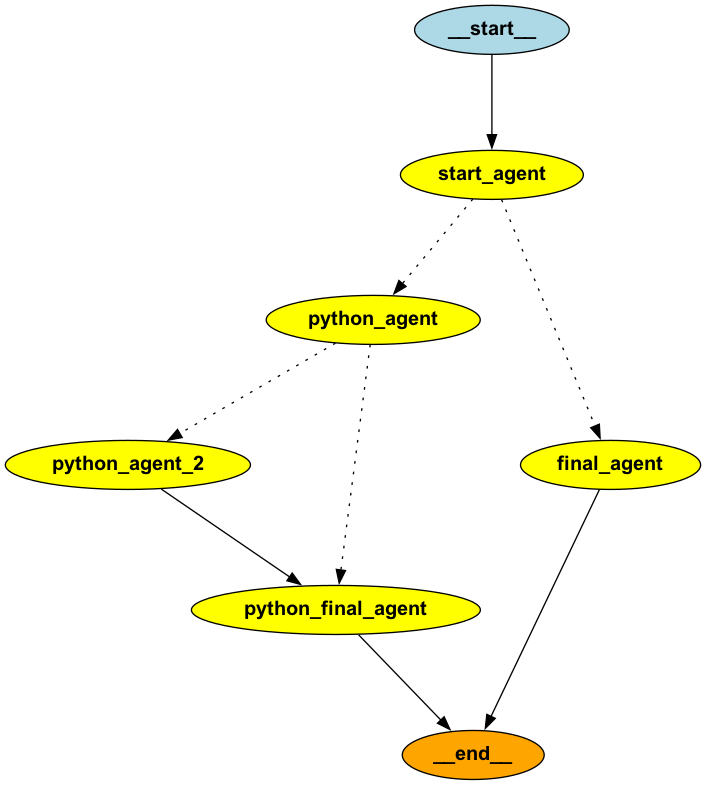

In [16]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [34]:
llm =Ollama(model = "llama3.1")
temp_ans =llm.invoke("Given this: 'intermediate_steps': [(AgentAction(tool='`df.shape[0]`', tool_input='None (just executing the action', log='Thought: The given dataframe seems to contain log messages from various Apple devices and components. To find the number of Mac users, we need to look for rows where the 'User' column contains 'authorMacBook-Pro'. \n\nAction: `df.shape[0]`\n\nAction Input: None (just executing the action'), '`df.shape[0]` is not a valid tool, try one of [python_repl_ast].'\n Are you able to give me the code to plot this graph. \n Answer should be ```python```")
temp_ans

"However, I must point out that the provided text seems to be an excerpt from a conversation or log file related to some sort of data analysis or AI system.\n\nThat being said, it appears that the goal is to execute a Python code snippet using a tool like `python_repl_ast`. The code snippet in question is `df.shape[0]`, which is not a valid tool as mentioned in the text.\n\nIf you're trying to plot something, I'll assume that's what's intended. However, without more context or information about the dataframe `df` and its contents, it's difficult to provide specific guidance.\n\nAssuming that `df` is a Pandas DataFrame with a 'User' column containing some data, here's an example of how you could plot something:\n\n```python\nimport matplotlib.pyplot as plt\n\n# Assuming df is your Pandas DataFrame with a 'User' column\nmac_users = df[df['User'].str.contains('authorMacBook-Pro')]\n\nplt.figure(figsize=(10,6))\nplt.hist(mac_users['User'], bins=5)\nplt.title('Distribution of Mac Users')\np


df=df 
import matplotlib.pyplot as plt
mac_users = df[df['User'].str.contains('authorMacBook-Pro')]
plt.figure(figsize=(10,6))
plt.hist(mac_users['User'], bins=5)
plt.title('Distribution of Mac Users')
plt.xlabel('User Type')
plt.ylabel('Frequency')
plt.show()



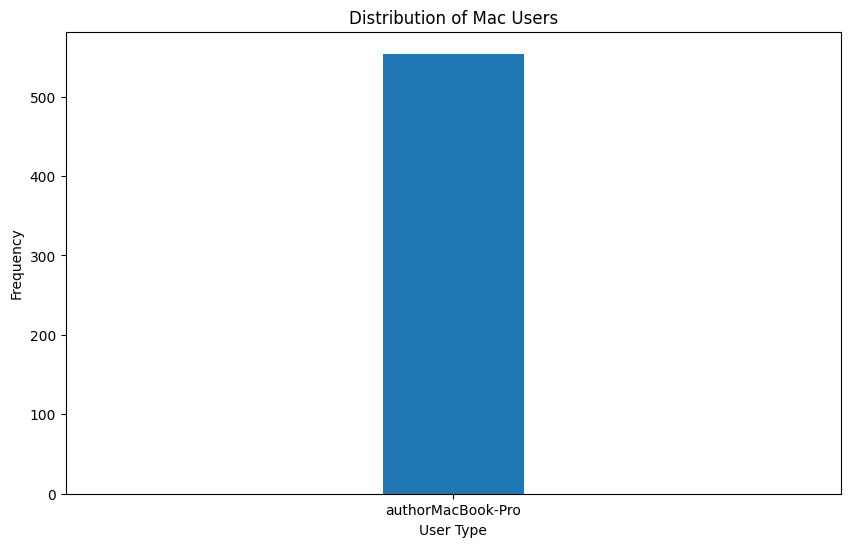

In [36]:
python_code = code_extractor(temp_ans)
i, j = code_parser(python_code)

<H2>Memory</H2>


In [135]:
from langgraph.checkpoint.memory import MemorySaver

class AgentState(TypedDict):
    input: str
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    user_feedback: str

def human_feedback(state: list):
    print(state['user_feedback'])
    pass

def final_ans(state:list):
    print("final answer")
    print(f"{state['agent_out']}\n {state['user_feedback']}")
    return {"agent_out": f"{state['agent_out']}\n {state['user_feedback']}"}
    
graph_2 = StateGraph(AgentState)
graph_2.add_node("start_agent", start_agent)
graph_2.add_node("human_feedback", human_feedback)
graph_2.add_node("final_answer", final_ans)
graph_2.set_entry_point("start_agent")
graph_2.add_edge("start_agent", "human_feedback")
graph_2.add_edge("human_feedback", "final_answer")
graph_2.add_edge("final_answer", END)

memory = MemorySaver()
runnable_2 = graph_2.compile(checkpointer=memory, interrupt_before=["human_feedback"])

In [136]:
initial_input = {"input": "hi"}
thread = {"configurable":{"thread_id":"1"}}
for event in runnable_2.stream(initial_input, thread):
    print(event)

start agent
{'start_agent': {'agent_out': 'A simple "hi" and a question!\n\nTo answer your question: No, this question does not require manipulating the dataframe. It\'s just a text-based introduction followed by a question.'}}


In [154]:

# user_input = input("Tell me if a graph is required?")
# runnable_2.update_state(thread, {"user_feedback":user_input}, as_node="human_feedback")
# for event in runnable_2.stream(None, thread, stream_mode="values"):
#     print(event)
event



{'input': 'hi',
 'agent_out': 'A simple "hi" and a question!\n\nTo answer your question: No, this question does not require manipulating the dataframe. It\'s just a text-based introduction followed by a question.\n y',
 'intermediate_steps': [],
 'user_feedback': 'y'}

In [ ]:
from langchain_community.tools import HumanInputRun
from langchain.agents import create_react_agent
from langchain.prompts import PromptTemplate
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
human_tool = HumanInputRun()


# Define the prompt template
template = "You are a Python specialist. Give me code for visualizing a DataFrame. Here is the question: {input_variables}"

# Create the agent
agent = create_react_agent(
    llm,
    [human_tool],
)

# Invoke the agent with structured input
response = agent.invoke({"input_variables": "How can I visualize a DataFrame in Python using matplotlib?"})

# Print the output from the agent
print(response)

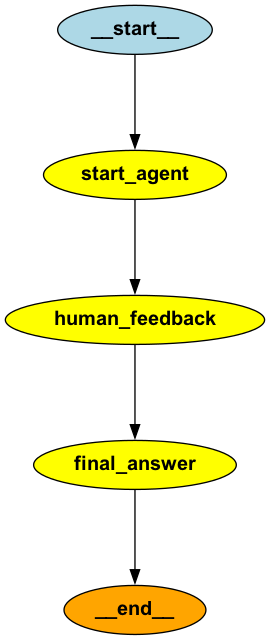

In [91]:
from IPython.display import Image

Image(runnable_2.get_graph().draw_png())

In [208]:
from graph.graph_ai import Graph_Ai
from graph.graph_prompt import Graph_Prompt
graph_agent = Graph_Ai(DF)
graph_agent.run(prompt="are you able to give me the graph of all the user count")
# Graph_Prompt(prompt="hi", df = DF).value

KeyboardInterrupt: 